In [1]:
# Build a Deep CNN Image Classifier with ANY Images - https://www.youtube.com/watch?v=jztwpsIzEGc&ab_channel=NicholasRenotte
# Any othere important comments here


In [3]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-2.9.1-cp39-cp39-win_amd64.whl (444.0 MB)
  Using cached tensorflow_gpu-2.9.1-cp39-cp39-win_amd64.whl (444.0 MB)


In [81]:
tf.compat.v1.enable_eager_execution()

In [82]:
import tensorflow as tf
import os

In [83]:
# Avoid OOM errors by setting GPU Memory Consumption Growth - Works only with Nvidia Graphics - 2022
# Prevent from geeting all GPU RAM's by tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [84]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

1.2 Remove all Iamges with wrong extensions etc.

In [85]:
import cv2
import imghdr
import shutil

In [86]:
data_dir = 'data_3'

In [87]:
image_extensions = ['jpeg', 'jpg', 'bmp', 'png'] # List of available extensions

In [88]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_extensions:
                print(f'Image not in extensions list {image_path}')
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with image {image_path}')
            #os.remove(image_path)

In [89]:
#tf.data.Dataset

In [90]:
import numpy as np
from matplotlib import pyplot as plt

In [91]:
# Loading Data - Create datasets with labels (subdirectory names). Split for n-counts of batches with size of 32 (default)
data = tf.keras.utils.image_dataset_from_directory('data_3') 

# It is working as Generator - do not loading files into memory
# Automaticly resize images - unified size of image 256x256 and create batches of images to maintain better prformance. 
# If our PC got not as much memory on GPU as it is needed, we can change size of batch ora change size of images 

Found 303 files belonging to 2 classes.


In [92]:
data_iterator = data.as_numpy_iterator() 

In [93]:
batch = data_iterator.next() # This line grab the batches from pipeline - again and again and again

In [94]:
# Images represented as numpy arrays
len(batch) # Print 2 - one for images in batches in te shape of numpy array
batch[0] # Print values from first position in batch
batch[0].shape # Show how many images are in a batch - in this case 32 it can be modified

(32, 256, 256, 3)

In [95]:
batch[1] # Labels of the images taken from directors contained in main directory

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1])

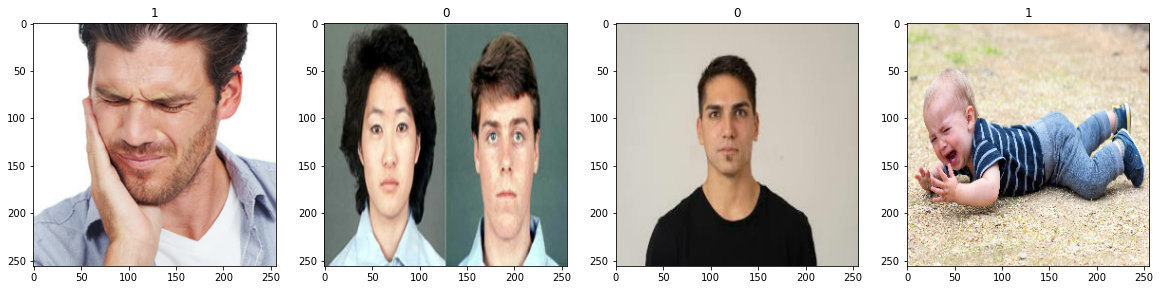

In [96]:
fig, ax = plt.subplots( ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

    # Quick check which label is for which picture. In this case 0 - happy, 1 - sad


2. Preprocess Data

2.1 Scale Data

In [97]:
data = data.map(lambda x,y: (x/255, y)) # Allows create transformation in pipline

In [98]:
scaled_iterator = data.as_numpy_iterator()

In [99]:
batch = scaled_iterator.next()

In [100]:
batch[0].min()

0.0

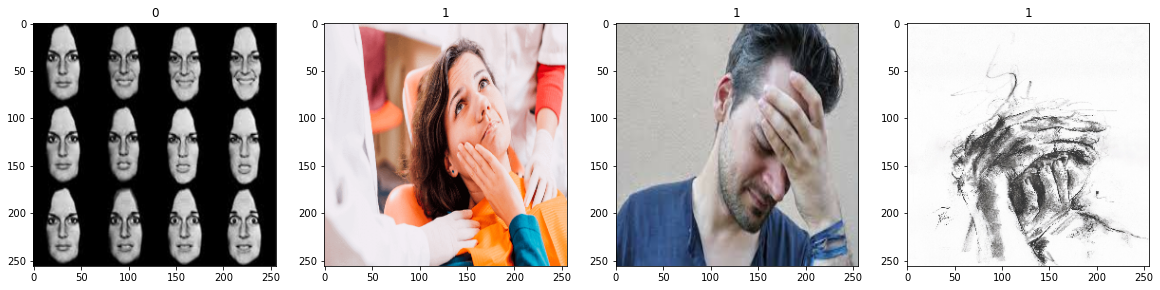

In [101]:
fig, ax = plt.subplots( ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

2.2 Split Data to Training and Testing 

In [102]:
len(data) # How many batches have we got. This example: 7 batches with 32 images each

10

In [103]:
# Split batches between training, validation and testing
# The sum of each has to equal the number of batches.
# In this case we got 7 batches: 4 for training, 2 for validation and 1 for testing.
train_size = int(len(data)*.7)-1
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

# train and val data is used in trianing process. Training data allow us to trian deep learning network, validation is for model checking
# test batch is to check the results of training our network -> used at the end

In [104]:
train_size

6

In [105]:
val_size

2

In [106]:
test_size

2

In [107]:
batches_size = train_size + val_size + test_size

In [108]:
batches_size

10

In [109]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# We allocate the batches of date to further training, validation and testing process. 
# .take() -> takes applied value of batches.
# .skip() -> skip applied value of batche.

# Important ! -> batches has to be shuffled before this process, and can not be shuffled after.
# It is, because we neeed to keep the order of taken batches to apply skip() function to work
# If we wanna shuffle data we has to back to: data = tf.keras.utils.image_dataset_from_directory('data'), and create new, shuffled batches

3. Deep model Creation

3.1 Build Deep Learning Model

In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [111]:
model = Sequential()

In [112]:
# 3 - Convlutinal Layers, 1 - Flatten layer, 2 - Dense layers

# Conolutional Layer and MaxPooling Layer
# We got: 16 filters catching key features from picture. 3x3 -> 3px by 3px filters size, 1 stride -> moves the 3x3 squer one pixel each time
# activation = 'relu' -> the function we use to change input date. Relu changes all negative numbers to 0, 
# and the positive numbers multipl by a special value. There are many of activation functions. 
# Non-linear deep learning models are overall better, because deep learning is not linear method
# input_shape - size of images go into model. The sizes has been changed earlier in the program

model.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D()) 
# MaxPoooling2D returns max value, found after activation function. It will condense and scale down the input image. It takes the vlaues from
# region. In default (2,2) -> reduce size by half


model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Number of filters form the channel Value,but we need one chanel value.
# Flatten layer Create one-dimensional dataset, which is required input in Dense layer
model.add(Flatten())


# So we got one-dimensional 256 outputs after Dense function, and later we get 1 output.
# Dense layers are the fully connected layers in the Keras framework,
# We got 256 neurons, and we feed them into Dense layer with relu activation.
# After the second Dense operation we expect the value between 0 and 1 -> due to sigmoid chracteristics
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [113]:
# W have t ocompile our model. We use 'adam' optimizer (one of many)
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [114]:
model.summary() # Allow us to see how the model is converting the input data

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

3.2 Train

In [115]:
logdir = "logs"

In [116]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [117]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])
# model.fit(): takes training date (dividie earlier in the code), epoches -> how many times we wnat to train our model 
# -> one epoch is runinng over entire training set of data
# the nwe pass our validation vlaues, so we can know how great performance has our model in real-time domain

Epoch 1/20
6/6 [==============================] - 8s 757ms/step - loss: 0.9658 - accuracy: 0.4896 - val_loss: 0.6618 - val_accuracy: 0.6094
Epoch 2/20
6/6 [==============================] - 6s 761ms/step - loss: 0.6512 - accuracy: 0.6094 - val_loss: 0.5702 - val_accuracy: 0.6562
Epoch 3/20
6/6 [==============================] - 6s 624ms/step - loss: 0.5803 - accuracy: 0.6250 - val_loss: 0.5123 - val_accuracy: 0.9062
Epoch 4/20
6/6 [==============================] - 5s 630ms/step - loss: 0.5054 - accuracy: 0.7760 - val_loss: 0.4696 - val_accuracy: 0.7812
Epoch 5/20
6/6 [==============================] - 5s 623ms/step - loss: 0.4446 - accuracy: 0.7500 - val_loss: 0.4272 - val_accuracy: 0.7656
Epoch 6/20
6/6 [==============================] - 5s 626ms/step - loss: 0.3410 - accuracy: 0.8750 - val_loss: 0.2665 - val_accuracy: 0.9062
Epoch 7/20
6/6 [==============================] - 5s 661ms/step - loss: 0.2520 - accuracy: 0.8802 - val_loss: 0.3397 - val_accuracy: 0.8125
Epoch 8/20
6/6 [====

3.3 Plot Performance

In [118]:
hist.history

{'loss': [0.96584153175354,
  0.6511848568916321,
  0.5803306102752686,
  0.505355715751648,
  0.44455966353416443,
  0.3410419225692749,
  0.251960813999176,
  0.2427903413772583,
  0.23143529891967773,
  0.17639906704425812,
  0.14412476122379303,
  0.0973978340625763,
  0.08430858701467514,
  0.03870461508631706,
  0.020857959985733032,
  0.007080667186528444,
  0.005474517121911049,
  0.0029292346443980932,
  0.010137387551367283,
  0.0049026645720005035],
 'accuracy': [0.4895833432674408,
  0.609375,
  0.625,
  0.7760416865348816,
  0.75,
  0.875,
  0.8802083134651184,
  0.8854166865348816,
  0.90625,
  0.9114583134651184,
  0.9270833134651184,
  0.984375,
  0.9791666865348816,
  0.9947916865348816,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9947916865348816,
  1.0],
 'val_loss': [0.6617884039878845,
  0.5702399015426636,
  0.5123181343078613,
  0.46964940428733826,
  0.42716848850250244,
  0.26648226380348206,
  0.3396512567996979,
  0.35810941457748413,
  0.18982842564582825,
  0.097194626

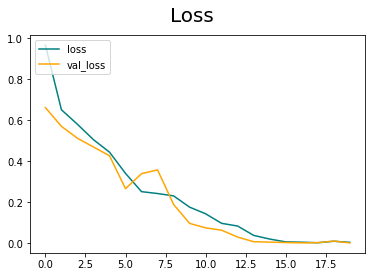

In [119]:
# Cause we saved information in hist variable, we cna now plot some interesting plots
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

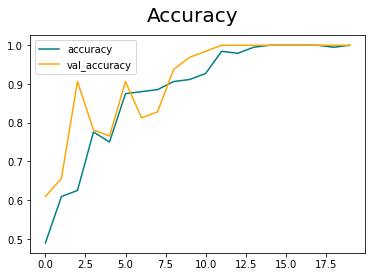

In [120]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

4. Evaluate Performance

4.1 Evaluate

In [121]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [122]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [123]:
for batch in test.as_numpy_iterator():
    X, y = batch
    ythat = model.predict(X)
    precision.update_state(y, ythat)
    recall.update_state(y, ythat)
    accuracy.update_state(y, ythat)
    

1/1 [==============================] - 0s 194ms/step


In [124]:
print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


4.2 Test

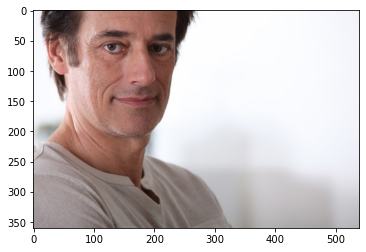

In [199]:
#img = cv2.imread('pain_test.JPG')
img = cv2.imread('neutral_test_v3.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

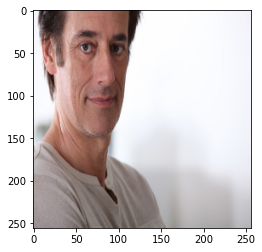

In [200]:
# We resized all batches of data to 256x256 size. The input data has to be the same size !!!
resize_img = tf.image.resize(img, (256, 256))
plt.imshow(resize_img.numpy().astype(int))
plt.show()

In [201]:
yhat = model.predict(np.expand_dims(resize_img/255, 0)) 
# The model expect the batch of data not a single image, so we have to wrap data into batch (deeper into the list)

1/1 [==============================] - 0s 54ms/step


In [202]:
yhat
#In this case 0 - happy, 1 - sad

array([[1.2320972e-05]], dtype=float32)

In [203]:
if yhat < 0.5:
    print('We are Normal Normal People, Yuhu :) !!!')
else:
    print("Hello Pain My Old Friend :( ")

We are Normal Normal People, Yuhu :) !!!


5. Save model

In [204]:
#from tensorflow.keras.models import load_model

In [210]:
#model.save(os.path.join('models', 'pain_detection_model_v2.h5'))

6. Reuse the model

In [236]:
new_model = load_model(os.path.join('models', 'pain_detection_model.h5'))

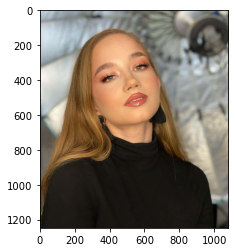

In [284]:
input_img = cv2.imread('neutral_test_v2.JPG')
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
plt.imshow(input_img)
plt.show()

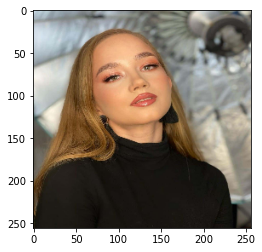

In [285]:
resized_img = tf.image.resize(input_img, (256, 256))
plt.imshow(resized_img.numpy().astype(int))
plt.show()

In [286]:
yhat_new = new_model.predict(np.expand_dims(resized_img/255, 0))

1/1 [==============================] - 0s 61ms/step


In [287]:
yhat_new

array([[0.00074012]], dtype=float32)

We are Normal Normal People, Yuhu :) !!!


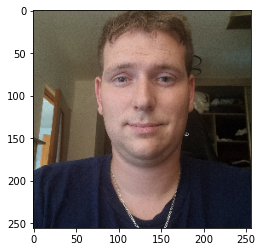

In [283]:
if yhat_new < 0.5:
    print('We are Normal Normal People, Yuhu :) !!!')
    plt.imshow(resized_img.numpy().astype(int))
else:
    print("Hello Pain My Old Friend :( ")
    plt.imshow(resized_img.numpy().astype(int))